In [1]:
import Pkg; Pkg.add(["Plots","Interact"]);
import Logging; Logging.disable_logging(Logging.Info)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


LogLevel(1)

In [2]:
const STATIC_LECTURE = false;

In [3]:
using LinearAlgebra;
using Plots; gr(); default(l=5, size=(900,550), label=false);
using Printf;
using Interact;
using SparseArrays;

BLAS.set_num_threads(1)

if STATIC_LECTURE
    default(fmt=:png)
    macro manipulate(v)
        return :($v; plot!())
    end
end

prettyprint(a) = map(x -> @sprintf("%+.2f", x), a)
sciprint(a) = map(x -> @sprintf("%+.2e", x), a)

function imshow(x; kwargs...)
    return heatmap(x
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=cgrad(:diverging_gwv_55_95_c39_n256, rev=true)
        ; kwargs...
    )
end
function imshowlog(x; kwargs...)
    return heatmap(max.(log.(abs.(x)), log(eps()))
        , aspect_ratio=:equal
        , framestyle=:none
        , yflip=true
        , c=cgrad(:linear_worb_100_25_c53_n256)
        ; kwargs...
    )
end
bigspy(x; kwargs...) = spy(x, m=4, c=:diverging_gwv_55_95_c39_n256; kwargs...)
p = plot!([0,1],[0,1]);

WebIO._IJuliaInit()

# The Lanczos Iteration

In [4]:
function arnoldi(A, b, n)
    m = size(A)[1]
    @assert n ≤ m
    Q = zeros(eltype(A), m, n+1)
    H̃ = zeros(eltype(A), n+1, n)
    Q[:,1] = b / norm(b)
    for j in 1:n
        v = A * Q[:,j]
        for i in 1:j # modified Gram-Schmidt
            # if A is Hermitian
            # we know a priori that
            # these values are zero if i < j - 1
            # H̃[i,j] = H̃[j,i] => reduce the number of
            # dot products further: we only need to
            # compute a dot product with q[:,j]
            H̃[i,j] = Q[:,i]' * v
            v -= Q[:,i] * H̃[i,j]
        end
        H̃[j+1,j] = norm(v)
        Q[:,j+1] = v / H̃[j+1,j]
    end
    return Q, H̃
end

arnoldi (generic function with 1 method)

In [14]:
function lanczos(A, b, n)
    m = size(A)[1]
    @assert n ≤ m
    Q = zeros(eltype(A), m, n+1)
    H̃ = zeros(eltype(A), n+1, n) # usually T̃
    Q[:,1] = b / norm(b)
    for j in 1:n
        v = A * Q[:,j]
        H̃[j,j] = α = Q[:,j]' * v # α_j = q_j' * A * q_j
        if j > 1
            β = H̃[j,j-1]
            v -= β * Q[:,j-1]
        end
        v -= α * Q[:,j]
        H̃[j+1,j] = β = norm(v)
        if j < n
            H̃[j,j+1] = β
        end
        Q[:,j+1] = v / β
    end
    return Q, H̃
end

lanczos (generic function with 1 method)

In [6]:
m = 50
n = 10
A = randn(m,m)
A = A + A'
b = randn(m)
Q, H = arnoldi(A, b, n);

In [7]:
norm(Q[:,1] - b / norm(b))

0.0

In [8]:
norm(H - UpperHessenberg(H))

0.0

In [9]:
norm(I - Q' * Q)

1.5047356975706993e-15

In [10]:
norm(A * Q[:,1:n] - Q * H) / norm(A)

1.634001523586601e-16

In [15]:
m = 50
n = 10
A = randn(m,m)
A = A + A'
b = randn(m)
Q, H = lanczos(A, b, n);

In [17]:
norm(Q[:,1] - b / norm(b))

0.0

In [18]:
norm(H - UpperHessenberg(H))

0.0

In [19]:
norm(I - Q' * Q)

5.992927814588608e-15

In [20]:
norm(A * Q[:,1:n] - Q * H) / norm(A)

1.4755345810416016e-16

### Summarizing

**T&B Theorem 36.1** The matrix $Q_n$ generated by `lanczos(A, b, n-1)` are reduced QR factors of the Krylov matrix,

$$
Q_n R_n = K_n(A,b).$$

The tridiagonal matrix $T_n = (\tilde{T}_n)_{1:n,1:n}$ is the corresponding projections,

$$T_n = Q_n^* A Q_n,$$

and the successive iterates are related by

$$A Q_n = Q_{n+1} \tilde T_n.$$

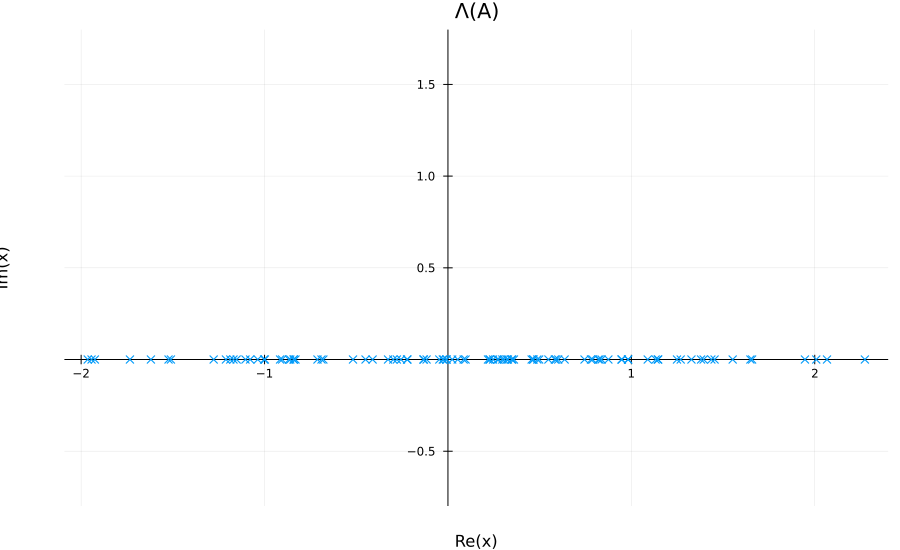

In [28]:
m = 100
Λ = randn(m)
p = plot(Complex{Float64}.(Λ), st=:scatter, framestyle=:origin, aspect_ratio = :equal, title = "Λ(A)", m=:x)

In [29]:
Q = qr(randn(Complex{Float64}, m, m)).Q
A = Q * Diagonal(Λ) * Q';
b = randn(m);

Plots.AnimatedGif("/home/tisaac/srv/rep/22-course-cse6643/mybinder/arnoldi-normal.gif")
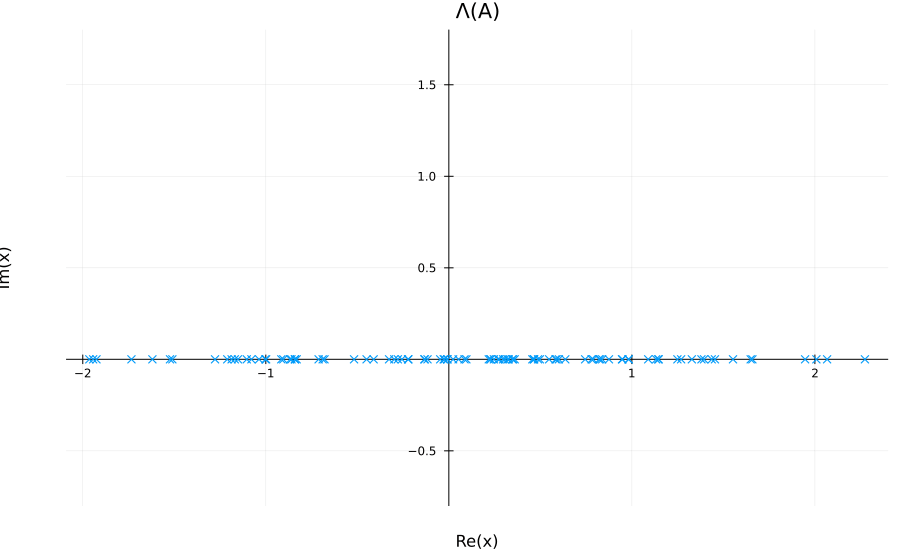

In [30]:
anim = Animation()
frame(anim, p)
for n in 1:20
    q = deepcopy(p)
    _, T̃ = lanczos(A, b, n)
    Θ = eigvals(T̃[1:n,1:n])
    plot!(q, Θ, st=:scatter, c=2, m=:diamond, title = "Λ(A), Λ(H($n))")
    frame(anim, q)
end
gif(anim, "arnoldi-normal.gif", fps=0.5)